In [1]:
#import necessary libraries

import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches

import numpy as np
from scipy.stats import gaussian_kde

# Load in Hail Data

In [2]:
# Load your hail data
df = pd.read_csv('hail_data.csv', parse_dates=['report_time'])

filtered_df = df

filtered_df 

,report_time,city,province,latitude,longitude,magnitude,qc_level
0,2019-07-18 23:20:00,NaN,AB,50.128720,-112.90135,38,1
1,2019-06-29 02:00:00,NaN,AB,54.601640,-110.06558,45,1
2,2019-07-24 00:45:00,NaN,AB,52.711000,-114.81000,64,1
3,2019-04-14 23:40:00,E Newbrook,AB,54.316800,-112.75400,13,1
4,2019-04-07 00:40:00,SE Nightingale,AB,51.127200,-113.25800,13,1
...,...,...,...,...,...,...,...
3526,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,21,1
3527,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,27,1
3528,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,-1,1
3529,2024-10-29 02:53:00,Crossfield,AB,51.428300,-114.02772,-1,1


In [3]:
# Define bounding box 
bbox = {'lat_max': 54, 'lon_max': -110, 'lat_min': 49, 'lon_min': -118}

In [4]:
# Filter for reports within the bounding box
mask = (
    (filtered_df['latitude'].between(bbox['lat_min'], bbox['lat_max'])) & 
    (filtered_df['longitude'].between(bbox['lon_min'], bbox['lon_max']))
)
df_bbox = filtered_df[mask].copy()

# Extract year
df_bbox['year'] = df_bbox['report_time'].dt.year
df_2023 = df_bbox[df_bbox['year'] == 2023]
df_2024 = df_bbox[df_bbox['year'] == 2024]

# Count reports per year
count_2023 = len(df_2023)
count_2024 = len(df_2024)

print(f"2023 reports in bounding box: {count_2023}")
print(f"2024 reports in bounding box: {count_2024}")


2023 reports in bounding box: 526
2024 reports in bounding box: 992


In [5]:
# Save 2024 data to a new CSV file
if not df_2024.empty:
    df_2024.to_csv('hail_reports_2024_filtered.csv', index=False)
    print("Successfully saved 2024 data to 'hail_reports_2024_filtered.csv'")
    
    try:
        test_load = pd.read_csv('hail_reports_2024_filtered.csv')
        print(f"Verification passed. Loaded {len(test_load)} records.")
    except Exception as e:
        print(f"Error verifying saved file: {e}")
else:
    print("No 2024 data found within the bounding box.")

Successfully saved 2024 data to 'hail_reports_2024_filtered.csv'
Verification passed. Loaded 992 records.


# Create Plots

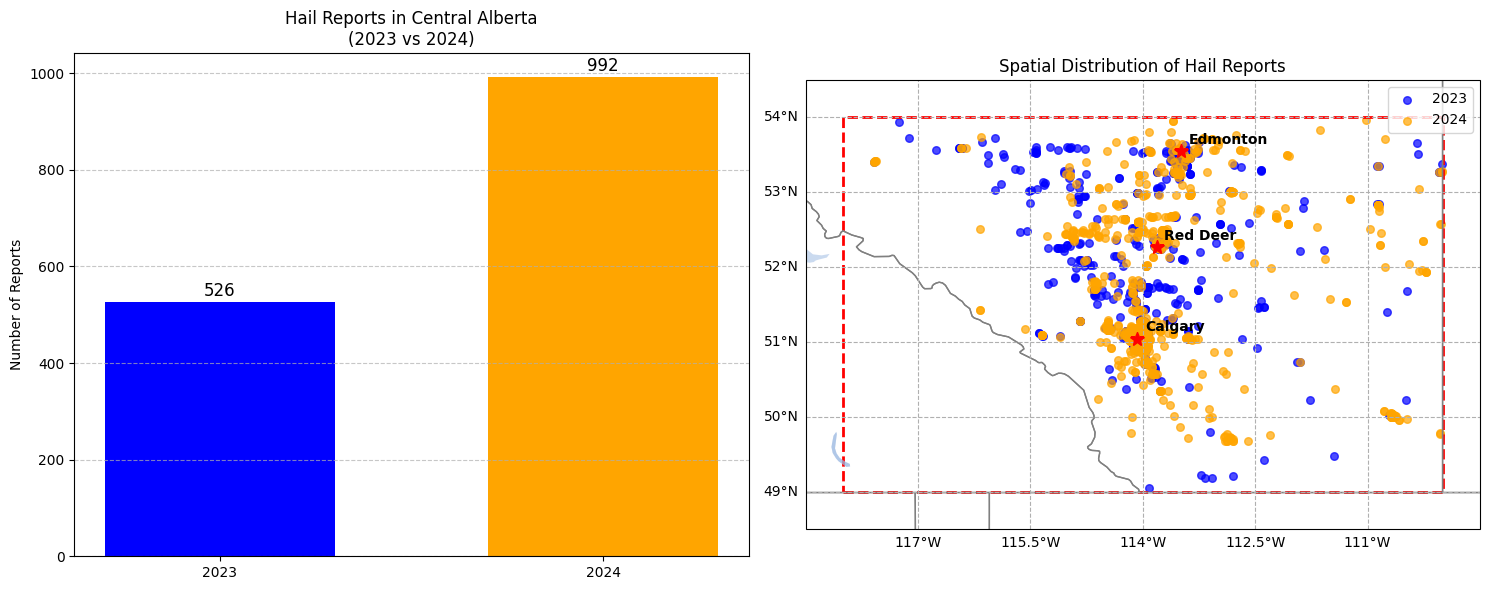

In [6]:

# Create figure with subplots
fig = plt.figure(figsize=(15, 6))

# City coordinates (latitude, longitude)
cities = {
    'Edmonton': (53.5461, -113.4938),
    'Calgary': (51.0447, -114.0719),
    'Red Deer': (52.2681, -113.8112)
}

# Bar Chart 
ax1 = plt.subplot(121)
ax1.bar(['2023', '2024'], [count_2023, count_2024], 
        color=['blue', 'orange'], width=0.6)
ax1.set_title('Hail Reports in Central Alberta\n(2023 vs 2024)')
ax1.set_ylabel('Number of Reports')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact counts above bars
for i, count in enumerate([count_2023, count_2024]):
    ax1.text(i, count+5, str(count), 
            ha='center', va='bottom', fontsize=12)

# Spatial Map 
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.LAND.with_scale('50m'), facecolor='white')
ax2.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.5)
ax2.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='gray')

# Plot hail reports
scatter_2023 = ax2.scatter(df_2023['longitude'], df_2023['latitude'],
                          c='blue', s=30, label='2023', alpha=0.7,
                          transform=ccrs.PlateCarree())
scatter_2024 = ax2.scatter(df_2024['longitude'], df_2024['latitude'],
                          c='orange', s=30, label='2024', alpha=0.7,
                          transform=ccrs.PlateCarree())

# Add bounding box 
bbox_patch = mpatches.Rectangle(
    (bbox['lon_min'], bbox['lat_min']),
    bbox['lon_max'] - bbox['lon_min'],
    bbox['lat_max'] - bbox['lat_min'],
    fill=False, color='red', linestyle='--', linewidth=2,
    transform=ccrs.PlateCarree()
)
ax2.add_patch(bbox_patch)

# Set map extent with buffer)
ax2.set_extent([bbox['lon_min']-0.5, bbox['lon_max']+0.5,
               bbox['lat_min']-0.5, bbox['lat_max']+0.5])

ax2.set_title('Spatial Distribution of Hail Reports')
ax2.legend(loc='upper right')

# Add gridlines
gl = ax2.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add city markers 
for city, (lat, lon) in cities.items():
    ax2.plot(lon, lat, 'r*', markersize=10, transform=ccrs.PlateCarree())
    ax2.text(lon+0.1, lat+0.1, city, fontsize=10, weight='bold',
            transform=ccrs.PlateCarree())


plt.tight_layout()
plt.savefig('hail_reports_with_bbox.png', dpi=300, bbox_inches='tight')
plt.show()

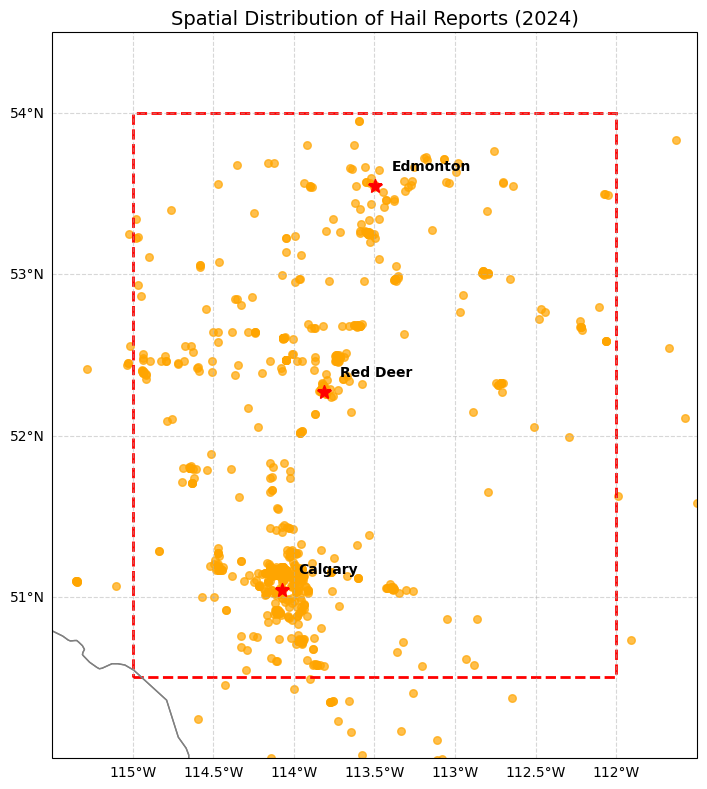

In [7]:
# Bounding box (adjust to fit your area of interest)
bbox = {
    'lat_min': 50.5,
    'lat_max': 54.0,
    'lon_min': -115.0,
    'lon_max': -112.0
}

cities = {
    'Edmonton': (53.5461, -113.4938),
    'Calgary': (51.0447, -114.0719),
    'Red Deer': (52.2681, -113.8112)
}

# ---- PLOTTING ----
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='white')
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='gray')

# Plot 2024 hail reports
ax.scatter(df_2024['longitude'], df_2024['latitude'], 
           c='orange', s=30, label='2024 Hail Reports', alpha=0.7,
           transform=ccrs.PlateCarree())

# Add bounding box
bbox_patch = mpatches.Rectangle(
    (bbox['lon_min'], bbox['lat_min']),
    bbox['lon_max'] - bbox['lon_min'],
    bbox['lat_max'] - bbox['lat_min'],
    fill=False, color='red', linestyle='--', linewidth=2,
    transform=ccrs.PlateCarree()
)
ax.add_patch(bbox_patch)

# Set extent around the bounding box
ax.set_extent([
    bbox['lon_min'] - 0.5, bbox['lon_max'] + 0.5,
    bbox['lat_min'] - 0.5, bbox['lat_max'] + 0.5
])

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add city markers and labels
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'r*', markersize=10, transform=ccrs.PlateCarree())
    ax.text(lon + 0.1, lat + 0.1, city, fontsize=10, weight='bold',
            transform=ccrs.PlateCarree())

# Title and save
ax.set_title('Spatial Distribution of Hail Reports (2024)', fontsize=14)
plt.tight_layout()
plt.savefig('hail_map_2024_only.png', dpi=300, bbox_inches='tight')
plt.show()


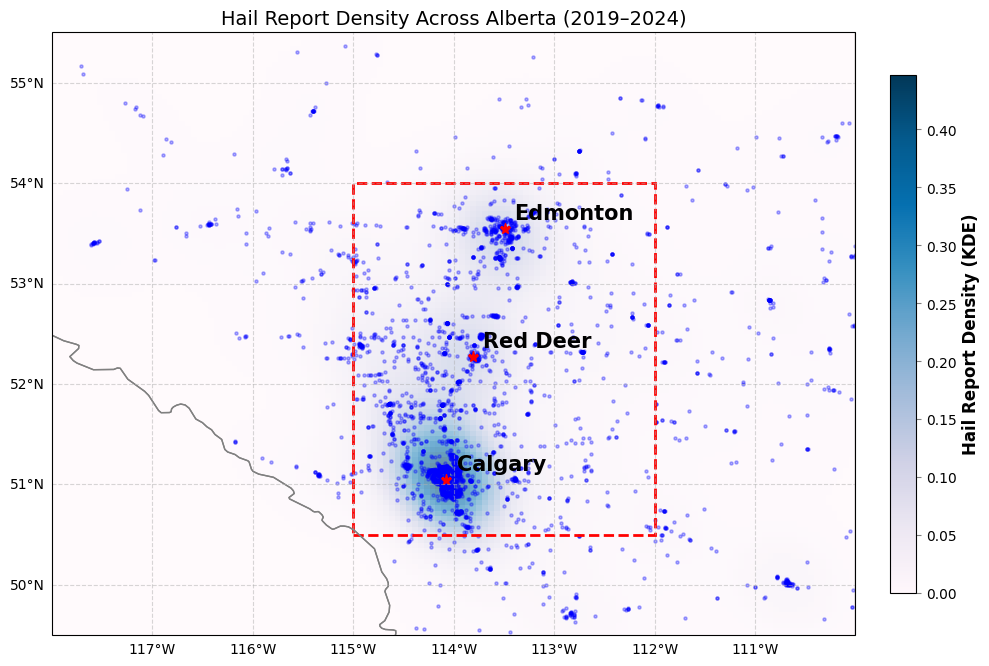

In [8]:
# Extract lat/lon from hail reports
x = filtered_df['longitude'].values
y = filtered_df['latitude'].values

# Fit KDE
kde = gaussian_kde(np.vstack([x, y]))
xmin, xmax = x.min() - 0.5, x.max() + 0.5
ymin, ymax = y.min() - 0.5, y.max() + 0.5

# Create grid
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
zz = np.reshape(kde(positions).T, xx.shape)

# Plot on Cartopy map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-118, -110, 49.5, 55.5])

# Add map features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='white')
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='gray')

# Show KDE density as a filled contour
density = ax.pcolormesh(xx, yy, zz, cmap='PuBu', shading='auto', alpha=0.6, transform=ccrs.PlateCarree())

# Raw hail report dots
ax.scatter(x, y, s=5, c='blue', alpha=0.3, transform=ccrs.PlateCarree(), label='Hail Reports')

# Bounding box
bbox = {
    'lat_min': 50.5,
    'lat_max': 54.0,
    'lon_min': -115.0,
    'lon_max': -112.0
}
bbox_patch = mpatches.Rectangle(
    (bbox['lon_min'], bbox['lat_min']),
    bbox['lon_max'] - bbox['lon_min'],
    bbox['lat_max'] - bbox['lat_min'],
    fill=False, color='red', linestyle='--', linewidth=2,
    transform=ccrs.PlateCarree()
)
ax.add_patch(bbox_patch)


cities = {
    'Edmonton': (53.5461, -113.4938),
    'Calgary': (51.0447, -114.0719),
    'Red Deer': (52.2681, -113.8112)
}
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'r*', markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + 0.1, lat + 0.1, city, fontsize=15, weight='bold', color = 'black', transform=ccrs.PlateCarree())


gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Title
ax.set_title('Hail Report Density Across Alberta (2019–2024)', fontsize=14)


norm = plt.Normalize(vmin=zz.min(), vmax=zz.max())
sm = plt.cm.ScalarMappable(cmap="PuBu", norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Hail Report Density (KDE)', fontsize=12, weight='bold')
cbar.ax.tick_params(labelsize=10, color='gray')


plt.tight_layout()
plt.savefig('hail_density_map.png', dpi=300, bbox_inches='tight')
plt.show()


